In [91]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [92]:
dc=pd.read_csv('doctor_information.csv')
pt=pd.read_csv('patient_information.csv')
apt=pd.read_csv('appointments.csv')

In [93]:
dc.describe()

,ID,Age,Type,Experience,Hospital Location,Patients in Queue,Patients Seen in Lifetime
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,7760.760210,54.933190,50.453050,14.971910,950.023910,15.537560,5505.415220
std,4184.189546,14.751454,28.879966,8.943474,29.193538,8.674896,2597.791948
min,500.000000,30.000000,1.000000,0.000000,900.000000,1.000000,1000.000000
25%,4132.000000,42.000000,25.000000,7.000000,925.000000,8.000000,3258.000000
50%,7771.000000,55.000000,50.000000,15.000000,950.000000,16.000000,5504.000000
75%,11391.250000,68.000000,76.000000,23.000000,975.000000,23.000000,7753.000000
max,15000.000000,80.000000,100.000000,30.000000,1000.000000,30.000000,10000.000000


In [94]:
pt.describe()

,ID,Age,Gender,Health Condition,Hospital Location,Preferred Doctor Type,Last Appointment
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,2997.029940,53.861420,1.501420,50.704980,950.039840,50.557780,183.981020
std,1158.672088,21.060809,0.500003,28.845212,29.068846,28.957266,105.450938
min,1000.000000,18.000000,1.000000,1.000000,900.000000,1.000000,1.000000
25%,1991.000000,36.000000,1.000000,26.000000,925.000000,26.000000,92.000000
50%,2992.000000,54.000000,2.000000,51.000000,950.000000,51.000000,185.000000
75%,4000.250000,72.000000,2.000000,76.000000,975.000000,76.000000,276.000000
max,5000.000000,90.000000,2.000000,100.000000,1000.000000,100.000000,365.000000


In [95]:
apt.describe()

,AppointmentID,PatientID,DoctorID,AppointmentDate,Rating
count,1382.000000,1382.000000,1382.000000,1382.000000,1382.000000
mean,2472.530391,2953.258321,7648.138929,182.993488,7.039074
std,1423.445547,1156.271622,4121.384723,103.058053,2.018361
min,2.000000,1001.000000,506.000000,1.000000,4.000000
25%,1244.250000,1964.000000,4067.250000,96.250000,5.000000
50%,2491.000000,2947.000000,7751.500000,184.000000,7.000000
75%,3634.500000,3900.000000,11302.000000,271.000000,9.000000
max,5000.000000,4996.000000,14994.000000,365.000000,10.000000


In [96]:
# find if every appointment has a doctor and a patient whose information is available

apt['DoctorID'].isin(dc['ID']).value_counts()
apt['PatientID'].isin(pt['ID']).value_counts()

PatientID
True    1382
Name: count, dtype: int64

In [97]:
docs=np.array(dc['ID'])
pts=np.array(pt['ID'])

In [98]:
docs[0]
pts[0]

2335

In [99]:
# use this to create x values for the model which will be a list of lists of the form [[doctor information],[patient information]]

doctor_info = []
patient_info = []

for i in range(len(apt)):
    inf_doc = dc[dc['ID'] == apt['DoctorID'][i]]
    inf_pt = pt[pt['ID'] == apt['PatientID'][i]]
    inf_doc = inf_doc.values[0]                         #there is a problem here
    inf_pt = inf_pt.values[0]                            #there is a problem here
    doctor_info.append(inf_doc)
    patient_info.append(inf_pt)

doctor_info = np.array(doctor_info)
patient_info = np.array(patient_info)

y = apt['Rating'].values.tolist()

In [100]:
# normalize the data

doctor_info = (doctor_info - np.mean(doctor_info))/np.std(doctor_info)
patient_info = (patient_info - np.mean(patient_info))/np.std(patient_info)

In [101]:
doctor_info[0]

array([ 0.98549717, -0.5660733 , -0.57267206, -0.58328746, -0.32191899,
       -0.5766887 ,  1.52889111])

In [102]:
patient_info[0]

array([ 1.01993402, -0.49551902, -0.55012994, -0.4918783 ,  0.30726151,
       -0.53010594, -0.385387  ])

In [122]:
# create training and testing data

train_size = int(0.8*len(doctor_info))
test_size = len(doctor_info) - train_size

train_doctor_info = doctor_info[:train_size]
train_patient_info = patient_info[:train_size]
train_doctor_info=np.array(train_doctor_info)
train_patient_info=np.array(train_patient_info)
train_y=np.array(y[:train_size])

train_x=tf.data.Dataset.from_tensor_slices((train_doctor_info,train_patient_info))
train_y=tf.data.Dataset.from_tensor_slices(train_y)
train_data=tf.data.Dataset.zip((train_x,train_y))
train_data=train_data.batch(32)

test_doctor_info = doctor_info[train_size:]
test_patient_info = patient_info[train_size:]
test_doctor_info=np.array(test_doctor_info)
test_patient_info=np.array(test_patient_info)
test_y=np.array(y[train_size:])

test_x=tf.data.Dataset.from_tensor_slices((test_doctor_info,test_patient_info))
test_y=tf.data.Dataset.from_tensor_slices(test_y)
test_data=tf.data.Dataset.zip((test_x,test_y))
test_data=test_data.batch(32)

In [104]:
input1=tf.keras.layers.Input(shape=(7,))
input2=tf.keras.layers.Input(shape=(7,))

a=tf.keras.layers.Dense(128,activation='relu')(input1)
b=tf.keras.layers.Dense(128,activation='relu')(input2)

a=tf.keras.layers.Dense(64,activation='relu')(a)
b=tf.keras.layers.Dense(64,activation='relu')(b)

a=tf.keras.layers.Dense(32,activation='relu')(a)
b=tf.keras.layers.Dense(32,activation='relu')(b)

c=tf.keras.layers.concatenate([a,b])

c=tf.keras.layers.Dense(16,activation='relu')(c)
c=tf.keras.layers.Dense(11,activation='softmax')(c)

model=tf.keras.models.Model(inputs=[input1,input2],outputs=c)

model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [105]:
model.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_45 (InputLayer)          [(None, 7)]          0           []                               
                                                                                                  
 input_46 (InputLayer)          [(None, 7)]          0           []                               
                                                                                                  
 dense_96 (Dense)               (None, 128)          1024        ['input_45[0][0]']               
                                                                                                  
 dense_97 (Dense)               (None, 128)          1024        ['input_46[0][0]']               
                                                                                           

In [109]:
# plot the model

tf.keras.utils.plot_model(model,show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [106]:
model.fit(train_data,epochs=100)

Epoch 1/100


35/35 [==============================] - 1s 1ms/step - loss: 2.3501 - accuracy: 0.1339 
Epoch 2/100
35/35 [==============================] - 0s 1ms/step - loss: 2.2452 - accuracy: 0.1484
Epoch 3/100
35/35 [==============================] - 0s 1ms/step - loss: 2.1316 - accuracy: 0.1448
Epoch 4/100
35/35 [==============================] - 0s 888us/step - loss: 2.0197 - accuracy: 0.1430
Epoch 5/100
35/35 [==============================] - 0s 1ms/step - loss: 1.9610 - accuracy: 0.1584
Epoch 6/100
35/35 [==============================] - 0s 1ms/step - loss: 1.9535 - accuracy: 0.1611
Epoch 7/100
35/35 [==============================] - 0s 1ms/step - loss: 1.9501 - accuracy: 0.1692
Epoch 8/100
35/35 [==============================] - 0s 1ms/step - loss: 1.9480 - accuracy: 0.1656
Epoch 9/100
35/35 [==============================] - 0s 823us/step - loss: 1.9460 - accuracy: 0.1647
Epoch 10/100
35/35 [==============================] - 0s 982us/step - loss: 1.9452 - accuracy: 0.1647
Epoch 11/100
3

In [123]:
# test the model

y_pred=model.predict(test_data)

9/9 [==============================] - 0s 1ms/step


In [113]:
y_pred=np.array(y_pred)

In [125]:
y_pred=np.argmax(y_pred,axis=1)

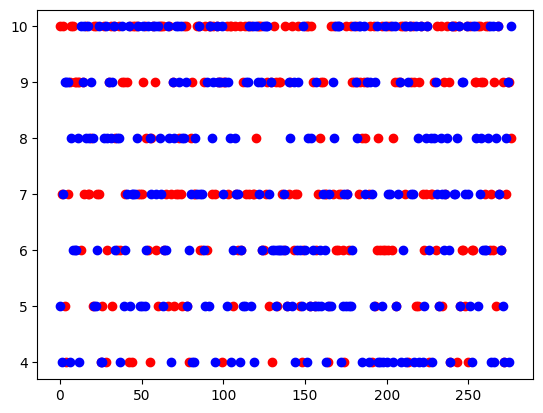

In [126]:
plt.scatter(range(len(y_pred)),y_pred,color='red')
plt.scatter(range(len(np.array(y[train_size:]))),np.array(y[train_size:]),color='blue')